In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
import pandas as pd

import HELP
gmod = HELP.get_model
makmod = HELP.make_spotmodel

import getMag
getMag = getMag.getMag

import getMag_hires
getMag_hires = getMag_hires.getMag_hires

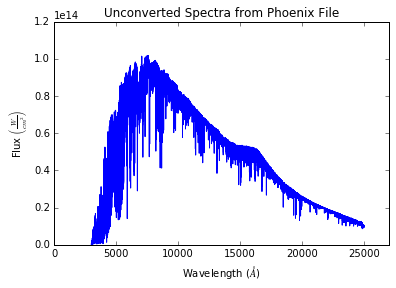

In [9]:
PhTemp = '4000'
SpTemp = '2300'
FillFactor = .2
wavelength,flux_Phoenix,PhTemp,SpTemp,FillFactor = makmod(PhTemp,SpTemp,FillFactor) #Creates spectrum for desired temps and fill-factor

plt.plot(wavelength,flux_Phoenix)
plt.xlim(0,27000)
plt.title('Unconverted Spectra from Phoenix File')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$')

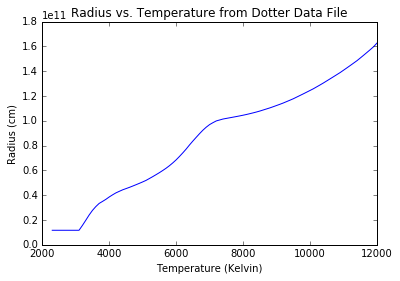

In [14]:
#Creating a method of finding stellar radius based on the input temperature from the Dotter Data. Note stellar age = log(8.1)
#Problem may occur however when reordering the data into ascending temperatures/radii. Data needs to be ascending for np.interp,
#but right now 'Temperatures' and 'Radii' data are not read as pairs, how to make a tuple of Temp/Radii?
#  ^^^ Above problems solved! ^^^

DotterData = open('models/Dotter_2014_isochrones','r')        #Opening the Dotter Data file and creating a readable table
names = DotterData.readline().split
DotterData.close()
DotterData=pd.read_table('models/Dotter_2014_isochrones', sep=r'\s+', engine='python')


DotterData['logAge']                                          #Look at the list of logAge data
Age_idx=np.where(DotterData['logAge']==8.1)                       #Create an index for the data where logAge = 8.1
TempData = 10**DotterData['logTeff'].values[Age_idx]              #Create array of temperature data, on absolute scale
RadData = 69.63*(10**9)*10**DotterData['logR_Ro'].values[Age_idx] #Create an array of radius data, on absolute scale, no ratio
Data = list(zip(TempData,RadData))                            #Combine the temp and rad data into a tuple array so temp and rad
                                                              #don't become miss-ordered
def getKey(item):
    return item[0]
SortedData = sorted(Data, key=getKey)                         #Sort the tuple array by ascending temperature

del SortedData[12]                                            #Remove the red giant data point

Temperaturesx = np.arange(2300,12100,100).tolist()            #Creating final lists for calculations
StrTemperaturesx = [str(i) for i in Temperaturesx]

Radiiy = np.interp(Temperaturesx,[i[0] for i in SortedData], [i[1] for i in SortedData])



plt.plot(Temperaturesx, Radiiy)
plt.title('Radius vs. Temperature from Dotter Data File')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (cm)')

#----Now the temperature vs radius data is in a smooth curve with correct units (Kelvin, cm) :D
#----for the upcoming flux conversion. <3 <3



#CONSIDER CREATING A FUNCTION OUT OF THIS CELL IN HELP FILE
#Could maybe use some variable cleanup later

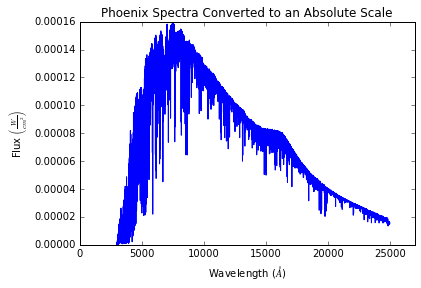

In [13]:
PhTemp_idx = StrTemperaturesx.index(PhTemp)
StarRad = Radiiy[PhTemp_idx]                         #StarRad is the stellar radius used for finding absolute flux

Flux = []
for i in range(len(flux_Phoenix)):
    y = flux_Phoenix[i]*(StarRad**2)/((3.0857*10**19)**2) #3.0857*10**19 is 10 parsecs in cm
    Flux.append(y)

Flux = np.asarray(Flux)
plt.plot(wavelength,Flux)
plt.xlim(0,27000)
plt.title('Phoenix Spectra Converted to an Absolute Scale')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'Flux $\left(\frac{W}{cm^2}\right)$')

[('U', 3650.0, -26.186780247342405), ('B', 4450.0, -27.432093608942676), ('V', 5510.0, -28.670231179306693), ('R', 6580.0, -29.421165408112113), ('I', 8060.000000000001, -30.202997148778937), ('J', 12350.000000000002, -31.278456366292453), ('H', 16620.0, -31.993403742851338), ('Ks', 21589.999999999996, -32.168181463201137)]


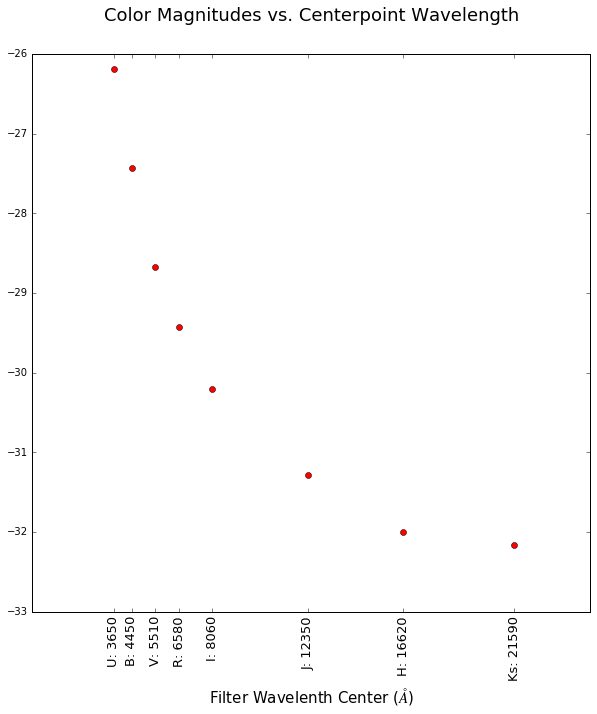

In [7]:
#initialize arrays of filter names
bands = np.array(['U','B','V','R','I','J','H','Ks'])
bands_hires = ['Ks','H','J']


#fill up a 3D array 'syn_phot' with: filter name, center point, magnitude
syn_phot = []
for i in range(len(bands)):
    x = getMag(bands[i],wavelength,Flux,'angstrom') #x returns three values; band, center, mag
    syn_phot.append(x)
    
#syn_phot_hires = []
#for i in range(len(bands_hires)):
#    y = getMag_hires(bands_hires[i],wavelength,tot_flux,'angstrom') #y returns three values; band, center, mag
#    syn_phot_hires.append(y)



print(syn_phot)
filters = [i[0] for i in syn_phot]
centers = [i[1] for i in syn_phot]
magnitudes = [i[2] for i in syn_phot]
plt.figure(figsize=(10,10))
plt.plot(centers,magnitudes,'ro')
plt.title('Color Magnitudes vs. Centerpoint Wavelength', fontsize=18,y=1.05)
xlab = ['U: 3650','B: 4450','V: 5510','R: 6580','I: 8060','J: 12350','H: 16620','Ks: 21590']
plt.xticks(centers,xlab,rotation='vertical',fontsize='13')
plt.xlabel('Filter Wavelenth Center ($\AA$)', fontsize=15)

#centers_hires = [i[1] for i in syn_phot_hires]
#magnitudes_hires = [i[2] for i in syn_phot_hires]
#plt.plot(centers_hires,magnitudes_hires,'bo')